In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [27]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

# Exploratory Data Analysis and Visualization

In [28]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [30]:
df.columns = ['Production']

In [31]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<AxesSubplot:xlabel='DATE'>

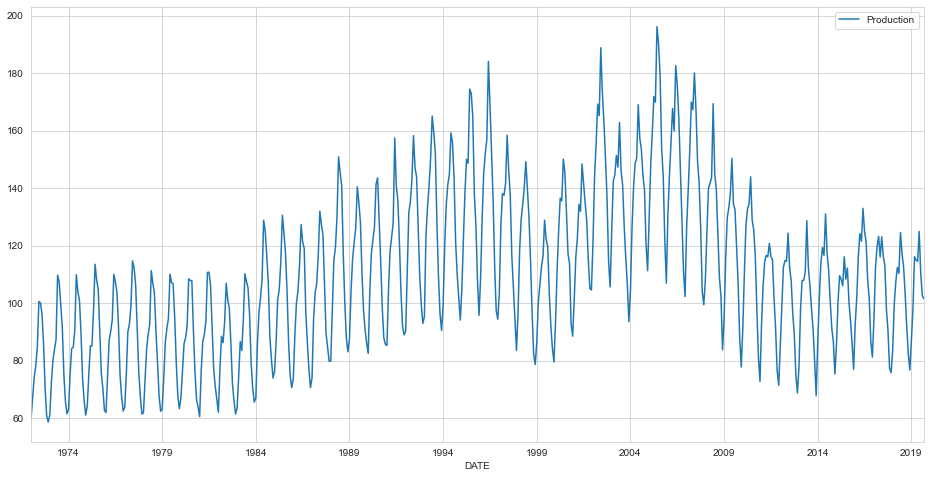

In [32]:
df.plot(figsize=(16,8))

# Preprocessing of Data

## Train Test Split

In [33]:
test_size = 24

In [34]:
test_ind = len(df)- test_size

In [35]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Scaling

In [36]:
from sklearn.preprocessing import MinMaxScaler

In [37]:
scaler = MinMaxScaler()

In [38]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [40]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# help(TimeseriesGenerator)

In [41]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [42]:
X, y = generator[1]

In [43]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKerasTF

In [45]:
n_features = train_scaled.shape[1]

## with "tanh" activation function

In [52]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 12, 32)            12416     
_________________________________________________________________
lstm_8 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [54]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

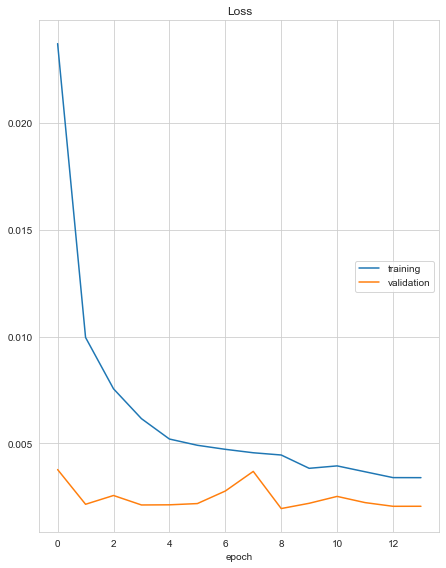

Loss
	training         	 (min:    0.003, max:    0.024, cur:    0.003)
	validation       	 (min:    0.002, max:    0.004, cur:    0.002)

537/537 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0021


In [55]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop,PlotLossesKerasTF()])

<AxesSubplot:>

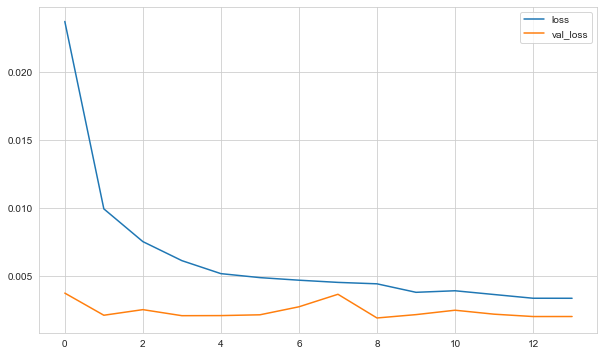

In [56]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [58]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [59]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [60]:
predictions = scaler.inverse_transform(predictions_scaled)

In [61]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,89.975
2017-11-01,77.438,88.404
2017-12-01,75.812,94.634
2018-01-01,83.434,104.170
2018-02-01,99.490,112.850
2018-03-01,107.315,119.385
2018-04-01,112.431,123.753
2018-05-01,110.354,124.976
2018-06-01,124.584,122.975


<AxesSubplot:xlabel='DATE'>

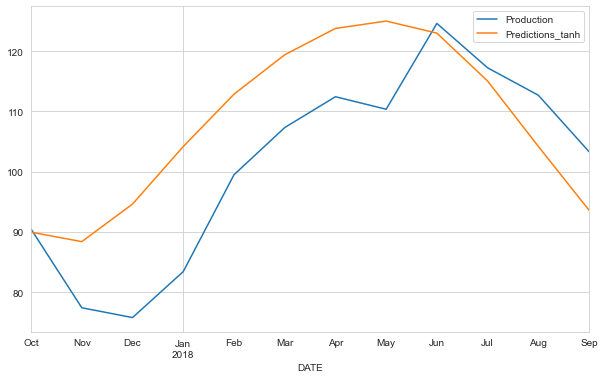

In [62]:
compare.plot()

In [63]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.3835526552031028 
mae: 10.365602090814216 
mse: 145.37103580582908 
rmse: 12.056991158901505


## with "relu" activation function

In [64]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_10 (LSTM)               (None, 12, 32)            12416     
_________________________________________________________________
lstm_11 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [66]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

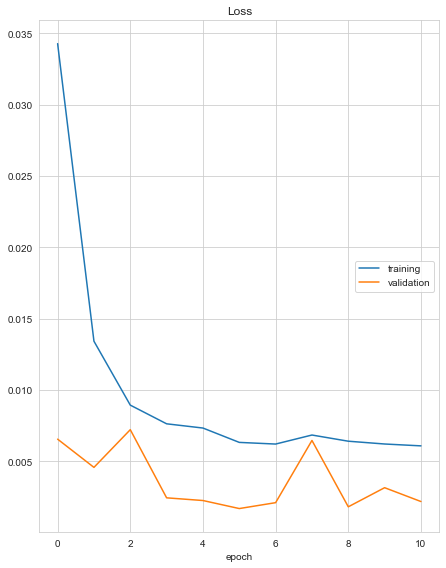

Loss
	training         	 (min:    0.006, max:    0.034, cur:    0.006)
	validation       	 (min:    0.002, max:    0.007, cur:    0.002)

537/537 [==============================] - 4s 7ms/step - loss: 0.0061 - val_loss: 0.0022


In [67]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop,PlotLossesKerasTF()])

<AxesSubplot:>

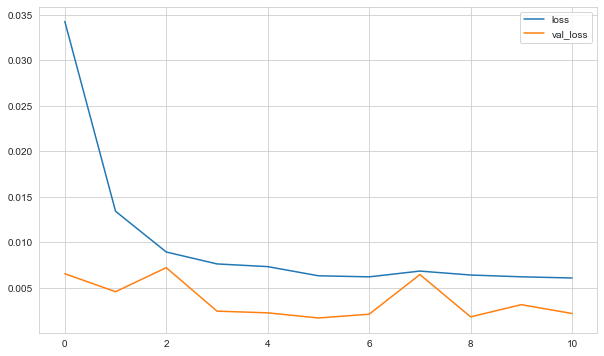

In [68]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [69]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [70]:
predictions = scaler.inverse_transform(predictions_scaled)

In [71]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,89.975,102.706
2017-11-01,77.438,88.404,89.318
2017-12-01,75.812,94.634,90.028
2018-01-01,83.434,104.170,101.843
2018-02-01,99.490,112.850,112.569
2018-03-01,107.315,119.385,117.838
2018-04-01,112.431,123.753,117.841
2018-05-01,110.354,124.976,118.102
2018-06-01,124.584,122.975,120.003


<AxesSubplot:xlabel='DATE'>

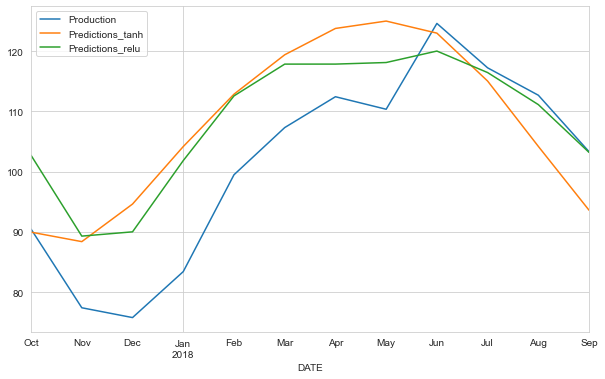

In [72]:
compare.plot()

In [73]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.566433501603623 
mae: 8.378247870944687 
mse: 102.24394912975687 
rmse: 10.111575007374315


# Retrain and Forecasting

In [74]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [75]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [76]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0273
Epoch 2/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0117
Epoch 3/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0073
Epoch 4/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0070
Epoch 5/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0068
Epoch 6/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0063
Epoch 7/10
561/561 [==============================] - 3s 6ms/step - loss: 0.0063
Epoch 8/10
561/561 [==============================] - 3s 6ms/step - loss: 0.0068
Epoch 9/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0062
Epoch 10/10
561/561 [==============================] - 4s 6ms/step - loss: 0.0061


In [77]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [78]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 98.59353307],
       [ 89.56752606],
       [ 85.95848633],
       [ 94.15899435],
       [106.56416298],
       [119.9439981 ],
       [119.55407987],
       [122.88287419],
       [127.4909936 ],
       [115.10191054],
       [109.07902762],
       [107.62120807]])

In [79]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [80]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [81]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,98.594
2019-11-01,89.568
2019-12-01,85.958
2020-01-01,94.159
2020-02-01,106.564
2020-03-01,119.944
2020-04-01,119.554
2020-05-01,122.883
2020-06-01,127.491
2020-07-01,115.102


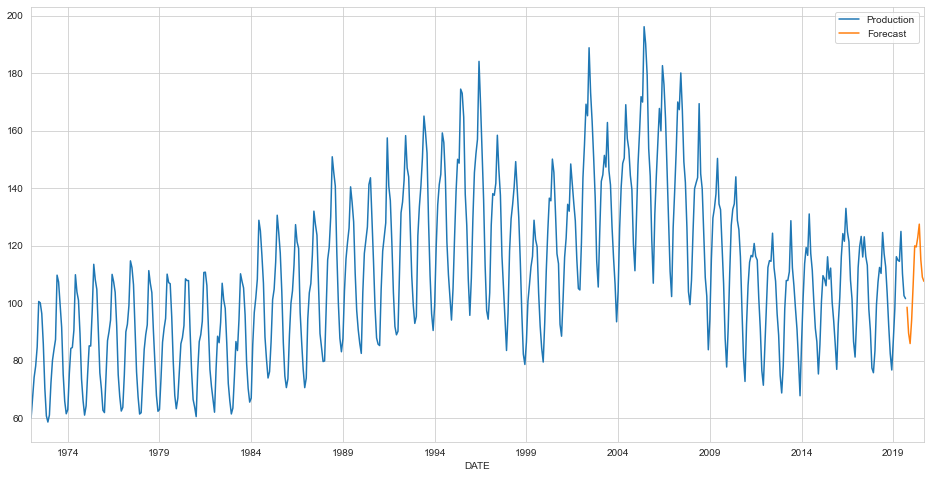

In [82]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

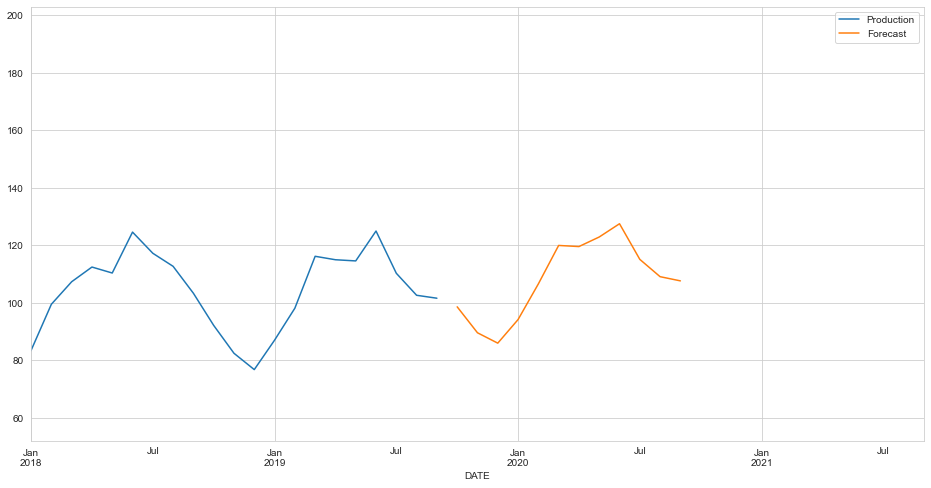

In [83]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')